In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import importlib.util

current_working_directory = os.getcwd()
# Go one directory back
parent_directory = os.path.dirname(current_working_directory)
# Construct the path to the module, assuming the module is in the parent directory
calculations_module_path = os.path.join(parent_directory, "calculations_module.py")
# Load the module
spec = importlib.util.spec_from_file_location("calculations_module", calculations_module_path)
calculations_module = importlib.util.module_from_spec(spec)
sys.modules["calculations_module"] = calculations_module
spec.loader.exec_module(calculations_module)

import scipy.stats
import itertools
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.lines import Line2D

In [3]:
tk_zs = np.array([0.0506, 0.5078, 1.0334, 1.2179, 1.4230, 1.6528, 1.9121, 2.0548, 2.3704, 3.9309, 5.3423])
zs_ = [tk_zs[3],tk_zs[4],tk_zs[7]]
theta1_input_ = [15., 18, 20]

In [10]:
class SimulationDataProcessor:
    def __init__(self, calculations_module, zs, theta1_input):
        self.parent_directory = "/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/"
        self.calculations_module = calculations_module
        self.zs = zs
        self.theta1_input = theta1_input
        self.process_simulation_data()

    def format_zs(self):
        return str(self.zs).replace('.', '_')

    def construct_filenames(self, zs_formatted):
        filename_theory = f"theory_values_{zs_formatted}_{self.theta1_input}.npy"
        filename_simulation = f"simulation_values_{zs_formatted}_{self.theta1_input}.npy"
        return filename_theory, filename_simulation

    def load_data(self, file_path):
        return np.load(file_path).T

    def process_simulation_data(self):
        zs_formatted = self.format_zs()
        filename_theory, filename_simulation = self.construct_filenames(zs_formatted)

        file_path_theory = self.parent_directory + filename_theory
        file_path_sim = self.parent_directory + filename_simulation

        l1_theory_data = self.load_data(file_path_theory)
        self.l1_prediction, self.pdf_prediction, self.kappa_prediction = l1_theory_data[1], l1_theory_data[0], l1_theory_data[2]

        self.mean_pred, self.variance_pred, self.S_3_pred, self.K_pred, self.norm_pred = self.calculations_module.get_moments(self.kappa_prediction, self.pdf_prediction)

        l1_simulation_data = self.load_data(file_path_sim)
        self.mean_l1_simulation_data = np.mean(l1_simulation_data[0:9], axis=0)
        bw = l1_simulation_data[11][1]-l1_simulation_data[11][0]
        factor = 12*2048*2048
        self.mean_sim, self.variance_sim, self.S_3_sim, self.K_sim, self.norm_sim = self.calculations_module.get_moments(l1_simulation_data[11], self.mean_l1_simulation_data/np.abs(l1_simulation_data[11]))
        
        non_zero_indices = np.where(self.mean_l1_simulation_data != 0)[0]

        self.kappa_sim = l1_simulation_data[11][non_zero_indices]
        self.l1_sim = self.mean_l1_simulation_data[non_zero_indices]
        self.residual = (self.l1_sim - self.l1_prediction[non_zero_indices]) / self.l1_sim
        self.l1_err = np.std(l1_simulation_data[0:9], axis=0)[non_zero_indices]
        self.l1_residual_err = self.l1_err / self.l1_sim
        ind = 12
        self.kappa_sim_subset = self.kappa_sim[::ind]
        self.l1_sim_subset = self.l1_sim[::ind]
        self.residual_subset = self.residual[::ind]
        self.l1_err_subset = self.l1_err[::ind]
        self.l1_residual_err_subset = self.l1_residual_err[::ind]

        self.sigma = np.sqrt(self.variance_pred)
        self.gaussian = scipy.stats.norm.pdf(self.kappa_sim, loc=self.mean_sim, scale=self.sigma)
        self.gaussian_l1 = self.calculations_module.get_l1_from_pdf(self.gaussian, self.kappa_sim)
        self.gaussian_residual = (self.l1_sim - self.gaussian_l1) / self.l1_sim
        self.gaussian_residual_subset = self.gaussian_residual[::ind]
        self.lower_bound_l1 = self.residual_subset -3.*self.l1_residual_err_subset
        self.upper_bound_l1 = self.residual_subset + 3.*self.l1_residual_err_subset
        return 

zs = zs_[0]
theta1_input = theta1_input_[1]
results = SimulationDataProcessor(calculations_module, zs, theta1_input)



In [14]:
os.getcwd()

'/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper'

     Type    zs  theta1          Mean  Variance  Skewness (S3)  Kurtosis (K)     Norm
Predicted 1.423    15.0 -4.179361e-10  0.000017     -44.122176      0.183658 1.000000
Simulated 1.423    15.0 -2.247731e-07  0.000017     -83.061572      0.622237 1.000571
Predicted 1.423    18.0 -3.555491e-09  0.000015     -43.910305      0.154840 1.000000
Simulated 1.423    18.0 -3.223853e-07  0.000015     -74.613046      0.438675 1.001698
Predicted 1.423    20.0 -2.890869e-09  0.000014     -43.715139      0.140105 1.000000
Simulated 1.423    20.0  1.739401e-07  0.000013     -76.663443      0.703153 1.108725


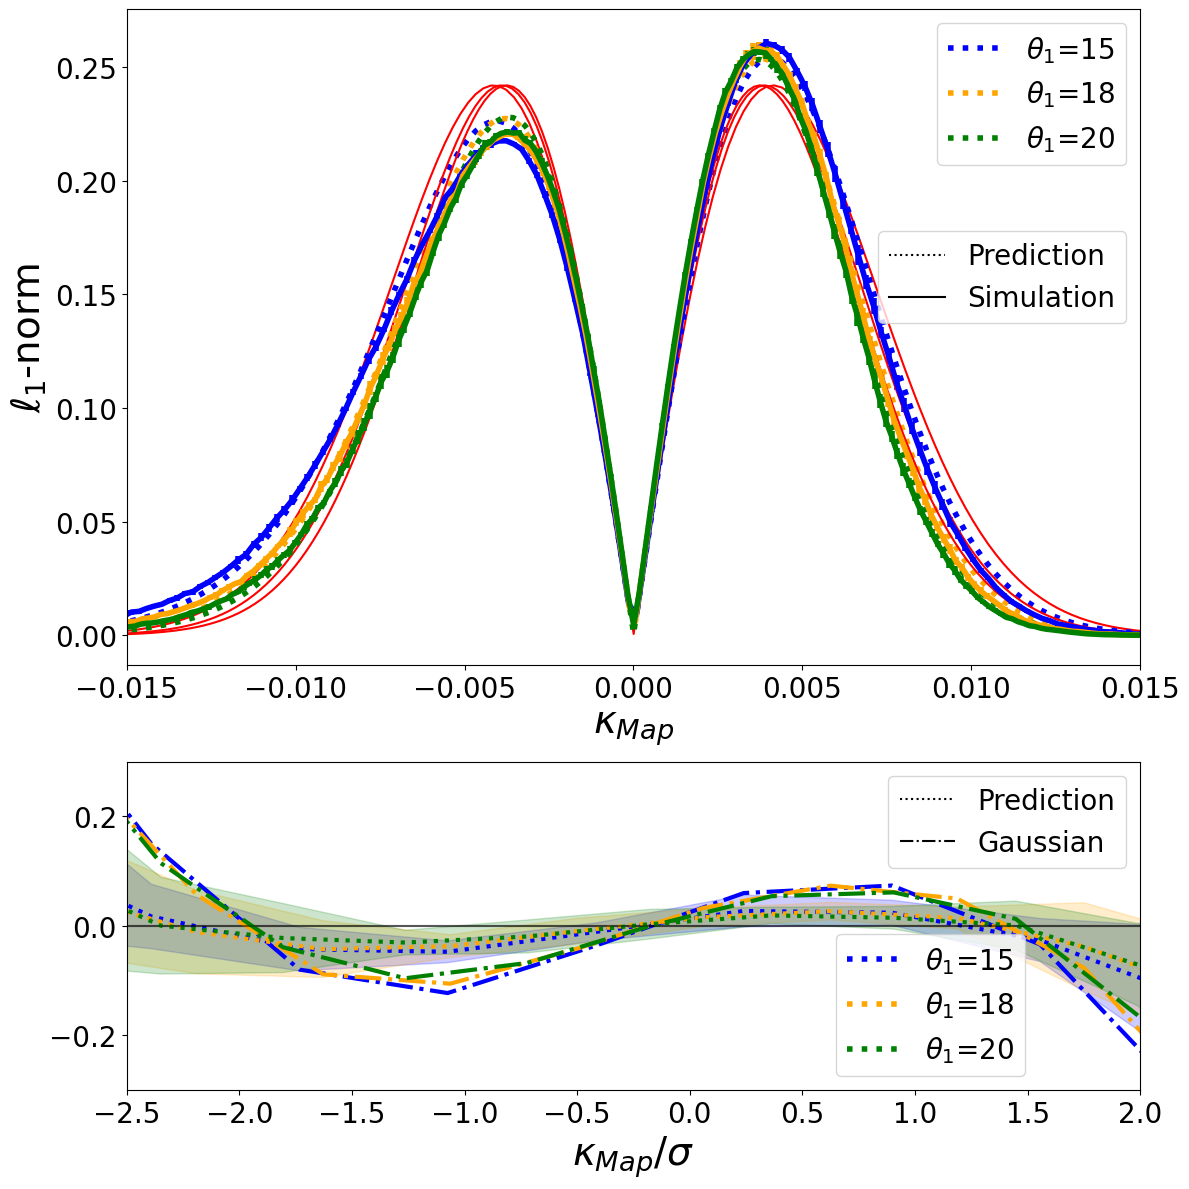

     Type     zs  theta1          Mean  Variance  Skewness (S3)  Kurtosis (K)     Norm
Predicted 1.2179      20 -3.048820e-09  0.000011     -55.583790      0.179514 1.000000
Simulated 1.2179      20 -3.764112e-07  0.000011     -94.528000      0.507194 1.002966
Predicted 1.4230      20 -2.890869e-09  0.000014     -43.715139      0.140105 1.000000
Simulated 1.4230      20  1.739401e-07  0.000013     -76.663443      0.703153 1.108725
Predicted 2.0548      20 -2.558617e-09  0.000024     -25.715793      0.080978 1.000000
Simulated 2.0548      20 -1.374156e-07  0.000024     -35.410846      0.151740 1.000632


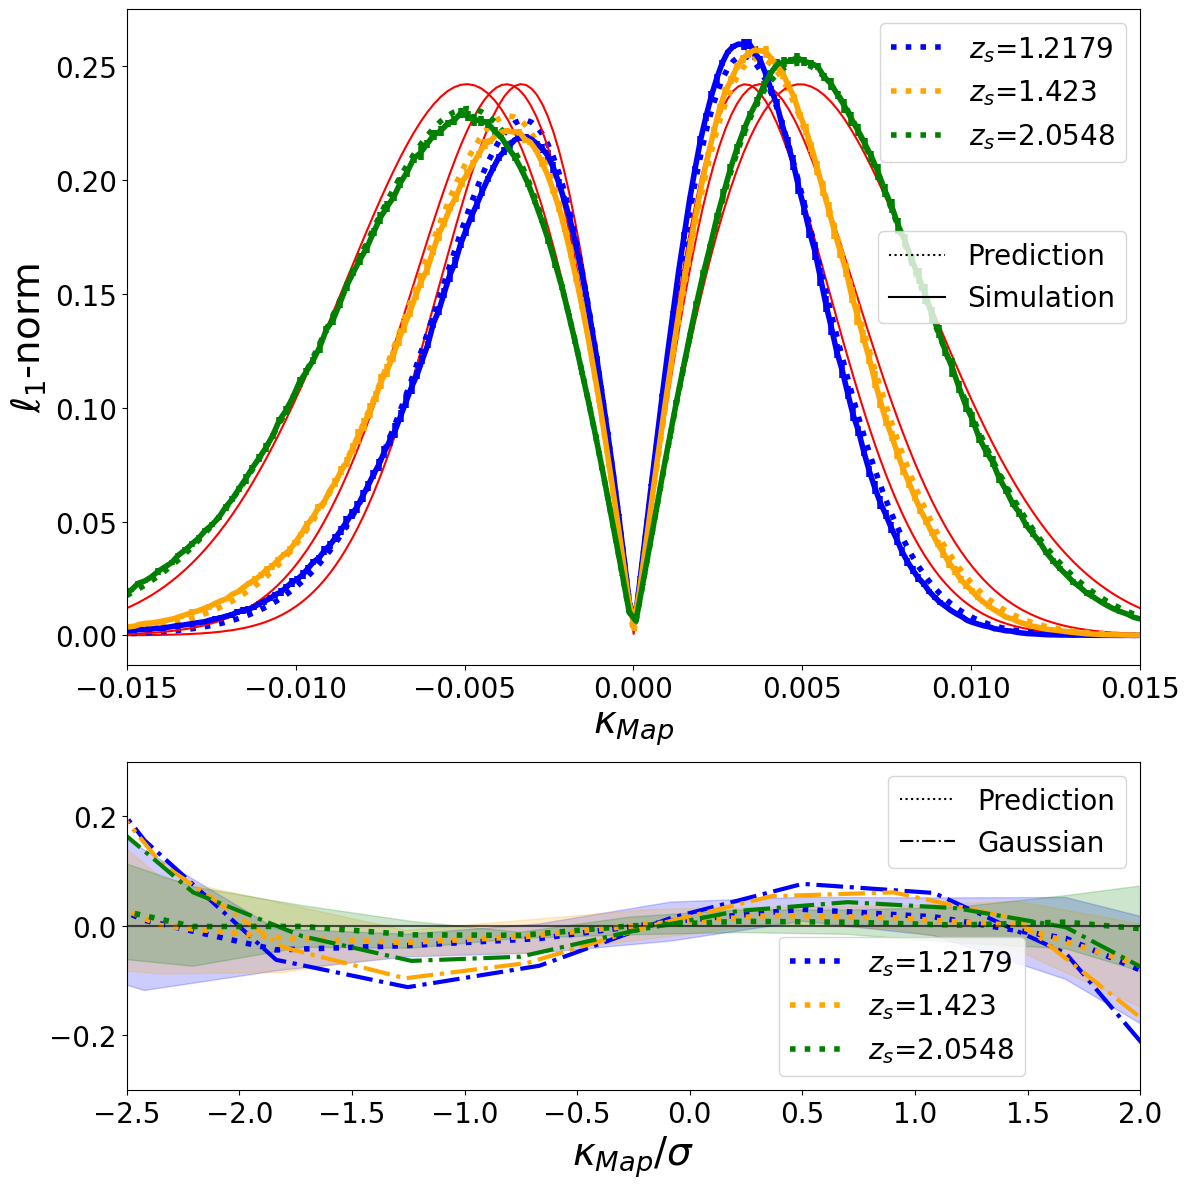

In [13]:
colours = ['blue', 'orange', 'green' ]
cc = itertools.cycle(colours)
plot_lines = []

fig = plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1, 0])  

legend_zs_pdf = []  
legend_zs_pdf_residual = []
legend_zs_l1 = []  
legend_zs_l1_residual = []  

label_size = 28
legend_size = 20

data = []
for i in range(1,len(zs_)-1):
    for j in range(len(theta1_input_)):
        zs = zs_[i]
        theta1_input = theta1_input_[j]
        results = SimulationDataProcessor(calculations_module, zs, theta1_input)

        c = next(cc)
        
        ax0.plot(results.kappa_sim,results.gaussian_l1,c='r')
        l1_sim = ax0.errorbar(results.kappa_sim, results.l1_sim,yerr = results.l1_err,color=c, lw=4)       
        l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=r'$\theta_1$=' + str(int(theta1_input)), lw=4)
         
        ax0.set_xlabel(r'$\kappa_{Map}$', size = label_size)
        ax0.set_ylabel(r'$\ell_1$-norm', size = label_size)
        ax0.set_xlim(-0.015,0.015)
        legend_zs_l1.append(l1_pred)
        
        l1_r2, = ax1.plot(results.kappa_sim_subset/results.sigma, results.gaussian_residual_subset, color=c, ls="-.", lw=3) 
        l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=r'$\theta_1$=' + str(int(theta1_input)), ls=":", lw=3) 

        ax1.set_xlim(-2.5,2.) 
        ax1.set_ylim(-0.3,0.3) 
        ax1.hlines(0,-2.5,2, color='black',alpha=0.3)
        ax1.set_xlabel(r'$\kappa_{Map}/\sigma$', size = label_size)
        ax1.fill_between(results.kappa_sim_subset/results.sigma, results.lower_bound_l1, results.upper_bound_l1, color=c, alpha=0.2)
        legend_zs_l1_residual.append(l1_r1)
        
        mu_pred, var_pred, s3_pred, kurt_pred, norm_pred = results.mean_pred, results.variance_pred, results.S_3_pred, results.K_pred, results.norm_pred
        mu_sim, var_sim, s3_sim, kurt_sim, norm_sim = results.mean_sim, results.variance_sim, results.S_3_sim, results.K_sim, results.norm_sim
        data.append(["Predicted", zs, theta1_input, mu_pred, var_pred, s3_pred, kurt_pred, norm_pred])
        data.append(["Simulated", zs, theta1_input, mu_sim, var_sim, s3_sim, kurt_sim, norm_sim])

# Create DataFrame
df = pd.DataFrame(data, columns=["Type","zs","theta1", "Mean", "Variance", "Skewness (S3)", "Kurtosis (K)", "Norm"])
print(df.to_string(index=False, max_colwidth=None, line_width=1000))

       
legend_zs_box = ax0.legend(handles=legend_zs_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1.0, 0.5), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)

legend_zs_box = ax1.legend(handles=legend_zs_l1, loc='lower right', bbox_to_anchor=(0.9, .0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-.", color='black', label='Gaussian')]
ax1.legend(handles=custom_legend, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/alltheta_z1_4.jpeg", dpi=600)
plt.show()

colours = ['blue', 'orange', 'green' ]
cc = itertools.cycle(colours)
plot_lines = []

fig = plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1, 0])  

legend_zs_pdf = []  
legend_zs_pdf_residual = []
legend_zs_l1 = []  
legend_zs_l1_residual = []  

label_size = 28
legend_size = 20

data = []
for i in range(len(zs_)):
    for j in range(2,len(theta1_input_)):
        zs = zs_[i]
        theta1_input = theta1_input_[j]
        results = SimulationDataProcessor(calculations_module, zs, theta1_input)

        c = next(cc)
        
        ax0.plot(results.kappa_sim,results.gaussian_l1,c='r')
        l1_sim = ax0.errorbar(results.kappa_sim, results.l1_sim,yerr = results.l1_err,color=c, lw=4)       
        # l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=r'$\theta_1$=' + str(int(theta1_input)), lw=4)
        l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=f'$z_s$={zs}', lw=4)
         
        ax0.set_xlabel(r'$\kappa_{Map}$', size = label_size)
        ax0.set_ylabel(r'$\ell_1$-norm', size = label_size)
        ax0.set_xlim(-0.015,0.015)
        legend_zs_l1.append(l1_pred)
        
        l1_r2, = ax1.plot(results.kappa_sim_subset/results.sigma, results.gaussian_residual_subset, color=c, ls="-.", lw=3) 
        # l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=r'$\theta_1$=' + str(int(theta1_input)), ls=":", lw=3) 
        l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=f'$z_s$={zs}', ls=":", lw=4)

        ax1.set_xlim(-2.5,2.) 
        ax1.set_ylim(-0.3,0.3) 
        ax1.hlines(0,-2.5,2, color='black',alpha=0.3)
        ax1.set_xlabel(r'$\kappa_{Map}/\sigma$', size = label_size)
        ax1.fill_between(results.kappa_sim_subset/results.sigma, results.lower_bound_l1, results.upper_bound_l1, color=c, alpha=0.2)
        legend_zs_l1_residual.append(l1_r1)
        mu_pred, var_pred, s3_pred, kurt_pred, norm_pred = results.mean_pred, results.variance_pred, results.S_3_pred, results.K_pred, results.norm_pred
        mu_sim, var_sim, s3_sim, kurt_sim, norm_sim = results.mean_sim, results.variance_sim, results.S_3_sim, results.K_sim, results.norm_sim
        data.append(["Predicted", zs, theta1_input, mu_pred, var_pred, s3_pred, kurt_pred, norm_pred])
        data.append(["Simulated", zs, theta1_input, mu_sim, var_sim, s3_sim, kurt_sim, norm_sim])

# Create DataFrame
df = pd.DataFrame(data, columns=["Type","zs","theta1", "Mean", "Variance", "Skewness (S3)", "Kurtosis (K)", "Norm"])
print(df.to_string(index=False, max_colwidth=None, line_width=1000)) 

legend_zs_box = ax0.legend(handles=legend_zs_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1.0, 0.5), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)

legend_zs_box = ax1.legend(handles=legend_zs_l1, loc='lower right', bbox_to_anchor=(0.9, .0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-.", color='black', label='Gaussian')]
ax1.legend(handles=custom_legend, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/allz_theta20.jpeg", dpi=600)
plt.show()
        